This notebook will make plots of the learning curves, as well as determine precision as a function of recall. It will also calculate statistics on training times.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [8]:
modelNames = ("tuned2", "custom3", "tuned3", "tuned5")
#modelNames = (["custom3"])
numberOfModelsToProduce = 6

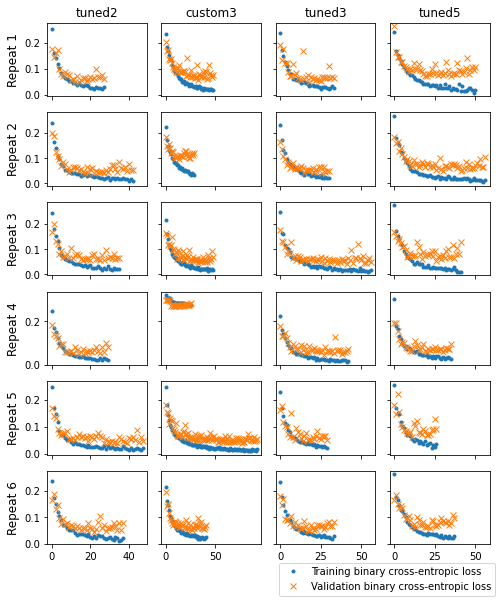

In [3]:
# LEARNING CURVES

#fig = plt.figure(figsize = (8,10))
fig, axes = plt.subplots(6,4, sharey="row",sharex="col", figsize=(7,8))

col=0
for modelName in modelNames:
    row = 0
    

    for i in np.arange(1,numberOfModelsToProduce+1):
        index = row*4+col
        #ax = plt.subplot(6,4,index)
        history = np.load("history_%s-%s.npy" % (modelName, i), allow_pickle=True).item()
        historydf = pd.DataFrame(history)
        
        if index == 1:
            axes[row, col].plot(historydf.index, historydf["loss"], ".", label="Training binary cross-entropic loss")
            axes[row, col].plot(historydf.index, historydf["val_loss"], "x", label="Validation binary cross-entropic loss")
        else:
            axes[row, col].plot(historydf.index, historydf["loss"], ".")
            axes[row, col].plot(historydf.index, historydf["val_loss"], "x")
        row += 1
    col += 1
        
        
cols = modelNames
rows = ["Repeat %i" % i for i in np.arange(1,6+1)]
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, size='large')
        
lgd = fig.legend(bbox_to_anchor=(1.00, -0.05), loc='lower right')
fig.tight_layout()

In [4]:
fig.savefig('training_curves.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

In [5]:
# Calculate training time statistics: mean time per epoch, number of epochs, stdevs of quantities

for modelName in modelNames:
    alltimes = []
    totalTimes = []
    epochs = []
    
    for i in np.arange(1,numberOfModelsToProduce+1):
        times = (np.load("times_%s-%s.npy" % (modelName, i), allow_pickle=True))
        for j in times:
            alltimes.append(j)
        totalTimes.append(sum(times))
        epochs.append(len(times))
        
    meanTimesPerEpoch = np.mean(alltimes)
    meanTotalTime = np.mean(totalTimes)
    meanEpochs = np.mean(epochs)
        
    print(modelName)
    print(meanTimesPerEpoch)
    print(np.std(alltimes))
    print(meanTotalTime)
    print(np.std(totalTimes))
    print(meanEpochs)
    print(np.std(epochs))
    print("\n")
        

tuned2
47.43547806290768
1.259404507000974
1763.0186013380687
327.51223825318914
37.166666666666664
6.938219432166216


custom3
19.53607428736157
0.44871222179748305
937.7315657933553
440.44164588362014
48.0
22.015146301277824


tuned3
23.745875198247653
0.28441053380662973
906.3009033997854
221.92350714445553
38.166666666666664
9.405967373014974


tuned5
23.261818817412237
0.2803201011080308
973.1194205284119
227.1318725733112
41.833333333333336
9.855906294648346




In [6]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit,root
import copy

image_size = (128, 128)
batch_size = 32
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "tfData-testing",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle = True,
    color_mode="grayscale"
)

Found 4401 files belonging to 2 classes.


In [7]:
# identifies and returns model with lowest loss on testing dataset

def findBestModel(models):
    i = 1
    scores = {}
    METRICS = [
          #keras.metrics.TruePositives(name='tp', thresholds=threshold),
          #keras.metrics.FalsePositives(name='fp', thresholds=threshold),
          #keras.metrics.TrueNegatives(name='tn',thresholds=threshold),
          #keras.metrics.FalseNegatives(name='fn',thresholds=threshold), 
          #keras.metrics.BinaryAccuracy(name='accuracy',threshold=threshold),
          keras.metrics.Precision(name='precision',thresholds=.5),
          keras.metrics.Recall(name='recall',thresholds=.5),
          #tfa.metrics.FBetaScore(name="fbeta", num_classes=1,beta=float(2),average='macro')
          #keras.metrics.SpecificityAtSensitivity(sensitivity=.95, name='SensAt95',threshold=threshold)
          #keras.metrics.AUC(name='auc'),
          #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        ]
    for model in models:
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss="binary_crossentropy",
            metrics=METRICS,
        )
        qual = (model.evaluate(test_ds))
        scores[qual[0]] = i
        i+=1
        
    losses = list(scores.keys())
    bestLoss = min(losses)
    bestModel = models[scores[bestLoss]-1]
    avgLoss = np.mean(losses)
    stdLoss = np.std(losses)
    
    return bestModel, bestLoss, avgLoss, stdLoss

In [8]:
# for each of the 4 architectures, find loss statistics and best model

bestModels = {}
for modelName in modelNames:
    models = []
    for i in np.arange(1,numberOfModelsToProduce+1):
        model = tf.keras.models.load_model("modelDirectory-%s-%s" % (modelName, i))
        models.append(model)
    
    bestModel, bestLoss, avgLoss, stdLoss = findBestModel(models)
    
    print("\n")
    print(modelName)
    print("Best loss: ", bestLoss)
    print("Average loss: ", avgLoss)
    print("Loss stdev: ", stdLoss)
    bestModel.summary()
    print("\n\n\n\n")
    
    bestModels[modelName] = bestModel

138/138 [==============================] - 7s 48ms/step - loss: 0.0445 - precision: 0.9014 - recall: 0.9497


tuned2
Best loss:  0.03810776770114899
Average loss:  0.04467548988759518
Loss stdev:  0.004734718427037453
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 128, 128, 222)     2220      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 64, 64, 222)      0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 64, 64, 196)       391804    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 32, 32, 196)      0         
 g2D)                                                            
                                 

In [9]:
# given a model, it will calculate its precision and recall on test dataset across 1000 evenly spaced thresholds
def getStats(model):
    quals = []
    lspace = np.linspace(0,.95,1000)
    for threshold in lspace:
        METRICS = [
          #keras.metrics.TruePositives(name='tp', thresholds=threshold),
          #keras.metrics.FalsePositives(name='fp', thresholds=threshold),
          #keras.metrics.TrueNegatives(name='tn',thresholds=threshold),
          #keras.metrics.FalseNegatives(name='fn',thresholds=threshold), 
          #keras.metrics.BinaryAccuracy(name='accuracy',threshold=threshold),
          keras.metrics.Precision(name='precision',thresholds=threshold),
          keras.metrics.Recall(name='recall',thresholds=threshold),
          #tfa.metrics.FBetaScore(name="fbeta", num_classes=1,beta=float(2),average='macro')
          #keras.metrics.SpecificityAtSensitivity(sensitivity=.95, name='SensAt95',threshold=threshold)
          #keras.metrics.AUC(name='auc'),
          #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        ]
        
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss="binary_crossentropy",
            metrics=METRICS,
        )
        
        qual = (model.evaluate(test_ds))
        quals.append(qual)
        
    x = []
    recall = []
    precision = []
    for i in np.arange(len(lspace)):
        x.append(lspace[i])
        recall.append(quals[i][2])
        precision.append(quals[i][1])
        
    #plt.plot(x,recall)
    #f = CubicSpline(x, recall)
    #g = CubicSpline(x, precision)
    #plt.plot(x,[f(i) for i in x])
    return (x, recall, precision)

In [10]:
%%time
stats = {}
for modelName in modelNames:
    model = bestModels[modelName]
    stats[modelName] = getStats(model)

138/138 [==============================] - 23s 154ms/step - loss: 0.0558 - precision: 0.9718 - recall: 0.6883
CPU times: total: 1d 2h 14min 57s
Wall time: 13h 22min 27s


In [15]:
statsCopy = copy.deepcopy(stats)
with open('stats.pkl', 'wb') as f:
    pickle.dump(statsCopy, f)

tuned2
Precision at 89.1%:    [0.95203709]
Precision at 63%:    [0.98441344]
Precision at 95%:    [0.90497747]
Precision at 99.7%:  [0.6502151]


custom3
Precision at 89.1%:    [0.95713743]
Precision at 63%:    [0.97373509]
Precision at 95%:    [0.93381593]
Precision at 99.7%:  [0.62383075]


tuned3
Precision at 89.1%:    [0.96750506]
Precision at 63%:    [0.9844133]
Precision at 95%:    [0.9454031]
Precision at 99.7%:  [0.32280658]


tuned5
Precision at 89.1%:    [0.93951955]
Precision at 63%:    [0.97421381]
Precision at 95%:    [0.87786446]
Precision at 99.7%:  [0.20214896]




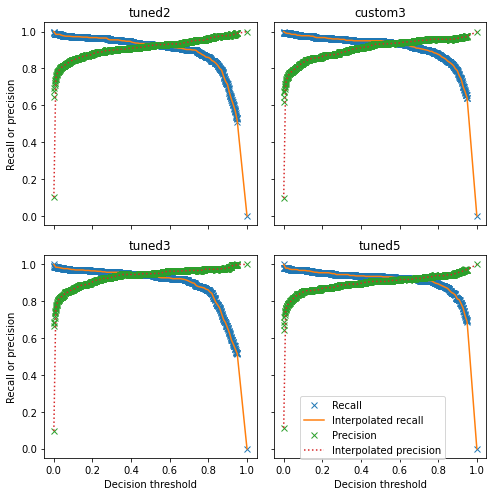

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [9]:
with open('stats-old.pkl', 'rb') as f:
    stats = pickle.load(f)
    
statsCopy = copy.deepcopy(stats)
fig, axes = plt.subplots(2,2, sharey="row",sharex="col", figsize=(7,7))

ind = 0


# given a recall, list of thresholds, list of recalls, and a precision spline, it will return the precision
def findPrecisionAt(recall, x, recalls, h):    
    
    g = interpolate.interp1d(x,[i-recall for i in recalls]) # generate spline that has root equal to the threshold at which recall is at given value
    thresholds = np.linspace(0,1,100000) # so many thresholds means that best recall will be closer to target recall
    recalls = [abs(g(i)) for i in thresholds] # this is effectively a root-finding expression
    return(h(thresholds[np.where(recalls == min(recalls))]))
    

for modelName in modelNames:
    
    (row, col) = [int(i) for i in format(ind, '02b')]
    
    plt.figure()
    (x, recall, precision) = statsCopy[modelName]
    # add limiting conditions
    x.append(1)
    recall.append(0)
    precision.append(1)
    
    # generate linear splines for interpolation
    f = interpolate.interp1d(x,recall)
    h = interpolate.interp1d(x,precision)
    
    
    if row == 0 and col == 0:
        axes[row,col].plot(x,recall,"x", label="Recall")
        axes[row,col].plot(np.linspace(0,1,100),[f(i) for i in np.linspace(0,1,100)], label="Interpolated recall")
        axes[row,col].plot(x,precision,"x", label="Precision")
        axes[row,col].plot(np.linspace(0,1,100),[h(i) for i in np.linspace(0,1,100)],":", label="Interpolated precision")
    else:
        axes[row,col].plot(x,recall,"x")
        axes[row,col].plot(np.linspace(0,1,100),[f(i) for i in np.linspace(0,1,100)])
        axes[row,col].plot(x,precision,"x")
        axes[row,col].plot(np.linspace(0,1,100),[h(i) for i in np.linspace(0,1,100)],":")
    
    axes[row,col].set_title(modelName)
    
    ind+=1
    
    print(modelName)
    print("Precision at 89.1%:   ",findPrecisionAt(0.891, x, recall, h))
    print("Precision at 63%:   ",findPrecisionAt(0.63, x, recall, h))
    print("Precision at 95%:   ",findPrecisionAt(0.95, x, recall, h))
    print("Precision at 99.7%: ",findPrecisionAt(0.997, x, recall, h))
    print("\n")
    
    

axes[0,0].set_ylabel("Recall or precision")
axes[1,0].set_ylabel("Recall or precision")

axes[1,0].set_xlabel("Decision threshold")
axes[1,1].set_xlabel("Decision threshold")

lgd = fig.legend(bbox_to_anchor=(0.90, .07), loc='lower right')
fig.tight_layout()
fig.savefig('recallPrecCurve.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)